# R-CNN 구현
## Step1. Selective Search로 약 2000개의 region proposal 생성
## Step2. 각 region proposal을 CNN에 입력해 classification 수행 
- 논문과는 조금 다른 점이 있다  
- 논문에서는 region proposal들을 crop 및 resize를 한 후 CNN을 통해 feature vector를 추출한 후  
- Linear SVM을 통해 classification을 수행하지만  
- 여기에선 CNN으로 classification까지 수행하도록 코드를 짰다.  
- 데이터 출처: kaggle  
- 이때 train data는 240개, test data는 120개가 있지만  
- region proposal 부분에서 데이터의 수가 기하급수적으로 늘어나 메모리가 부족한 탓에 train은 50개, test는 30개만 가지고 진행함  
- 또한 region proposal도 train 과정에서는 500개, test에서는 50개까지만 제한을 했다

## Packages and Modules

In [1]:
# package and module
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET

from r_cnn_data import get_data, show_sample
from r_cnn_utils import get_iou, get_data_with_nms, selective_search
from r_cnn_test import r_cnn_test, compare_image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,7]

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [4]:
path = './fruits/train'
train_image, train_anno = get_data(path, cut_number=50)

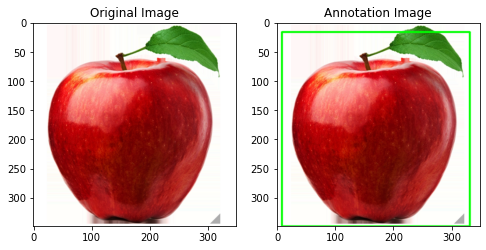

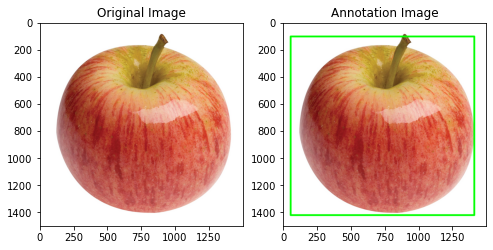

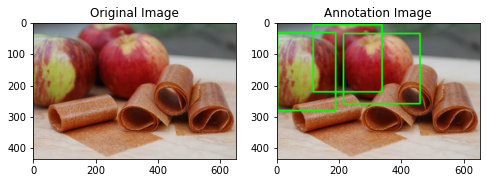

In [5]:
# 원본 이미지와 ground truth box 보여주기 
show_sample(3, train_image, train_anno)

## Selective Search

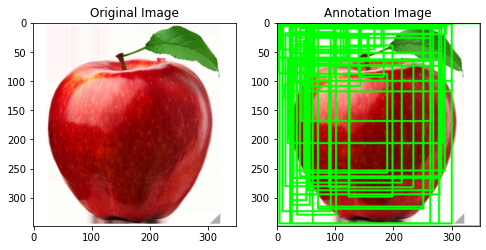

In [6]:
# selective search 샘플 50개
show_sample(1, train_image, np.expand_dims(selective_search(train_image[0])[:50], axis=0))

In [7]:
# selective search를 수행한 후 bounding box를 잘라내 resize하는 코드
train_images, train_labels = [], []

for i in tqdm(range(len(train_image))):
    bbox = train_anno[i]
    for box in bbox:
        # selective search 수행
        image = train_image[i]
        ss_results = selective_search(image)
        s = 0
        for ss in ss_results:
            x1, y1, x2, y2 = ss
            
            positive_sample_count = 0
            negative_sample_count = 0
            
            # IoU 얻기
            iou = get_iou(box, ss)
            if s<500:
                if iou > 0.7:
                    if positive_sample_count < 20:
                        img_crop = image[y1:y1+y2, x1:x1+x2]
                        resized = cv2.resize(img_crop, (224,224), cv2.INTER_AREA)
                        train_images.append(resized)
                        train_labels.append(1)
                        positive_sample_count += 1
                else:
                    if negative_sample_count < 20:
                        img_crop = image[y1:y1+y2, x1:x1+x2]
                        resized = cv2.resize(img_crop, (224,224), cv2.INTER_AREA)
                        train_images.append(resized)
                        train_labels.append(0)
                        negative_sample_count += 1    
            s += 1

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print(train_images.shape, train_labels.shape)

(45104, 224, 224, 3) (45104,)


## Load VGG16 model

In [9]:
# VGG16 불러오기
vgg = VGG16(include_top=True, weights='imagenet')

for layer in vgg.layers[:-2]:
    layer.trainable = False

# classification을 수행하는 레이어 추가
x = vgg.get_layer('fc2')
last_output = x.output
x = tf.keras.layers.Dense(1, activation='sigmoid')(last_output)

model = Model(inputs=vgg.input, outputs=x)
model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Model Training to get weights

In [10]:
# model training
EPOCH = 3
history = model.fit(train_images, train_labels,
                    batch_size=64,
                    epochs=EPOCH,
                    validation_split=0.2,
                    shuffle=True)

Epoch 1/3
564/564 [==============================] - 55s 88ms/step - loss: 0.0825 - accuracy: 0.9950 - val_loss: 0.0107 - val_accuracy: 0.9952
Epoch 2/3
564/564 [==============================] - 44s 78ms/step - loss: 0.0093 - accuracy: 0.9973 - val_loss: 0.0127 - val_accuracy: 0.9989
Epoch 3/3
564/564 [==============================] - 44s 78ms/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 0.0212 - val_accuracy: 0.9924


In [11]:
model.save('r_cnn_classification.h5')

In [12]:
# ground truth box인 경우에만 positive sample이자 라벨 1로,
# iou가 0.3보다 작은 경우에는 negative sample이자 라벨 0으로 설정
train_images, train_labels = get_data_with_nms(train_image, train_anno)

0it [00:00, ?it/s]

In [13]:
X_train = np.array(train_images)
y_train = np.array(train_labels)
y_train = to_categorical(y_train)

## Model Training

In [14]:
model = tf.keras.models.load_model('r_cnn_classification.h5')
x = model.get_layer('fc2').output
y = Dense(2, activation='softmax')(x)

final_model = Model(inputs=model.input, outputs=y)
final_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
final_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [15]:
# model training
history = final_model.fit(X_train, y_train,
                          batch_size=64,
                          epochs=50,
                          verbose=1,
                          shuffle=True,
                          validation_split=0.2)

Epoch 1/50
5/5 [==============================] - 3s 602ms/step - loss: 5.2716 - accuracy: 0.8261 - val_loss: 9.4798 - val_accuracy: 0.8261
Epoch 2/50
5/5 [==============================] - 0s 75ms/step - loss: 0.4977 - accuracy: 0.9710 - val_loss: 4.0456 - val_accuracy: 0.8696
Epoch 3/50
5/5 [==============================] - 0s 76ms/step - loss: 0.2275 - accuracy: 0.9891 - val_loss: 4.1355 - val_accuracy: 0.8551
Epoch 4/50
5/5 [==============================] - 0s 74ms/step - loss: 0.0663 - accuracy: 0.9855 - val_loss: 4.1199 - val_accuracy: 0.8551
Epoch 5/50
5/5 [==============================] - 0s 73ms/step - loss: 0.0422 - accuracy: 0.9928 - val_loss: 3.6526 - val_accuracy: 0.8551
Epoch 6/50
5/5 [==============================] - 0s 76ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 3.5320 - val_accuracy: 0.8551
Epoch 7/50
5/5 [==============================] - 0s 75ms/step - loss: 1.5239e-04 - accuracy: 1.0000 - val_loss: 3.4733 - val_accuracy: 0.8551
Epoch 8/50
5/5 [======

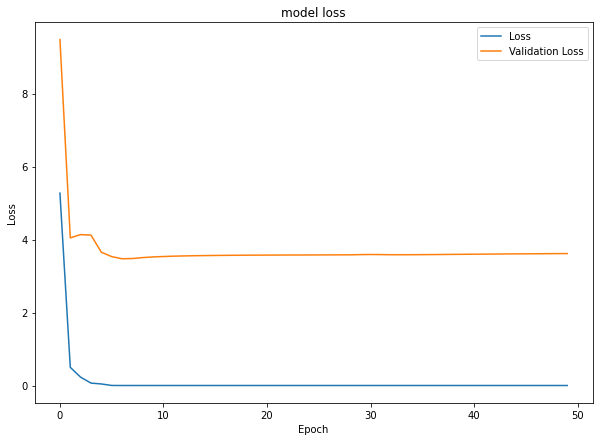

In [16]:
# check losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

## Test Model

In [17]:
# load test data
path = './fruits/test'
test_image, test_anno = get_data(path, cut_number=30)

In [18]:
# test 진행
test_predicted = r_cnn_test(test_image, final_model)

  0%|          | 0/30 [00:00<?, ?it/s]

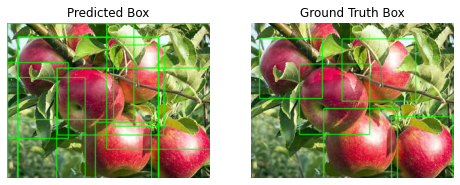

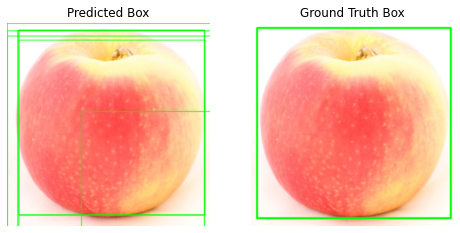

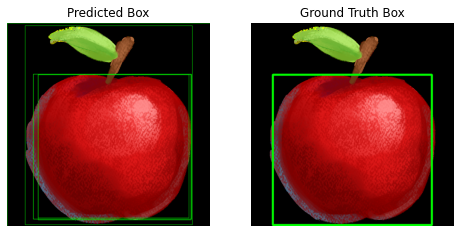

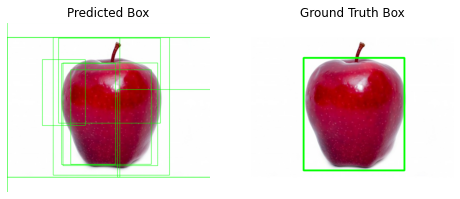

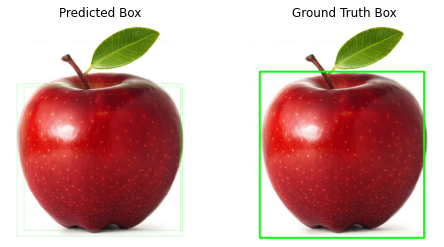

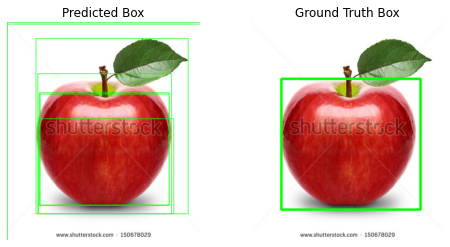

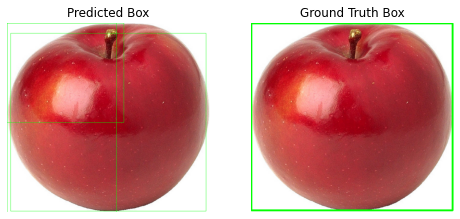

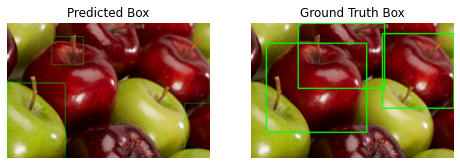

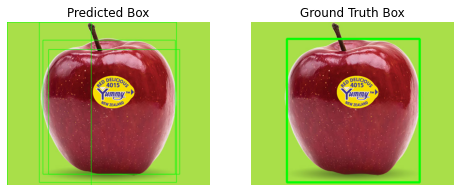

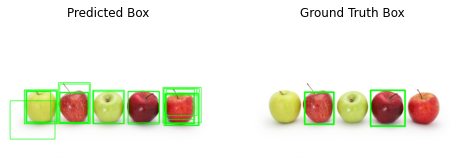

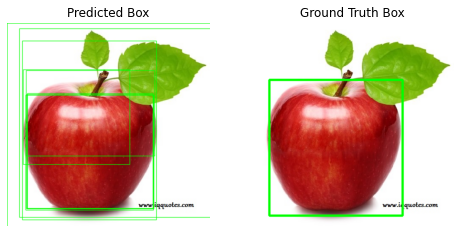

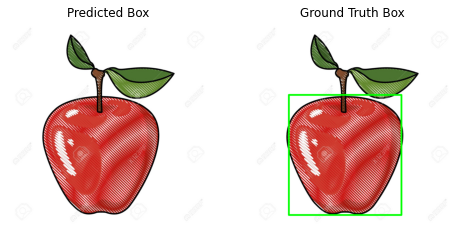

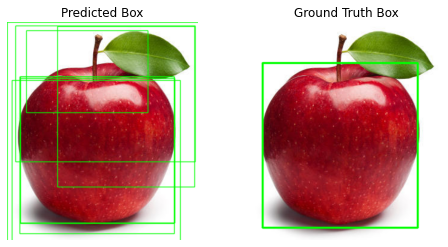

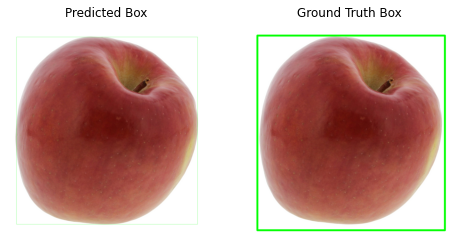

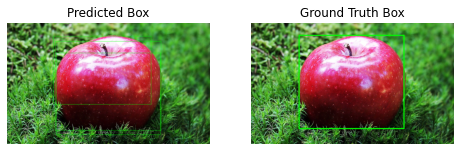

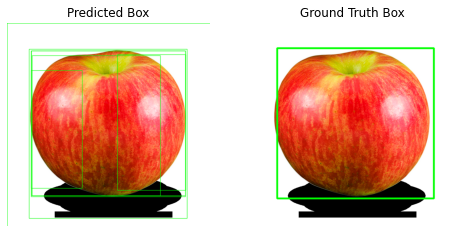

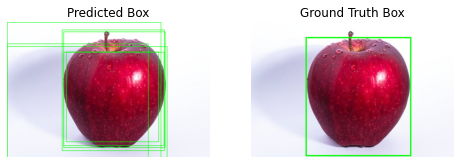

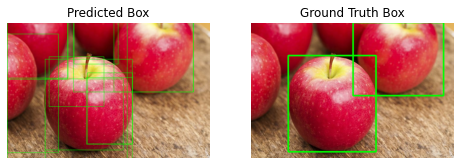

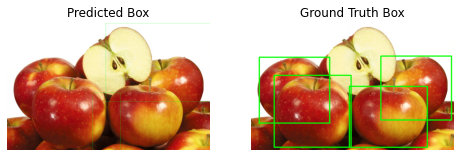

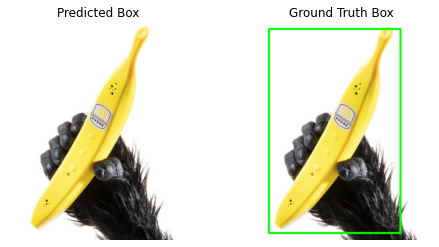

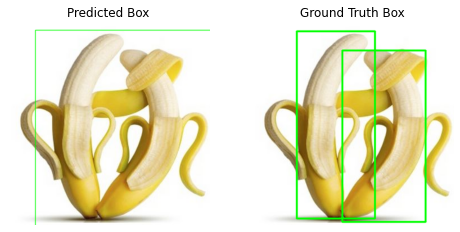

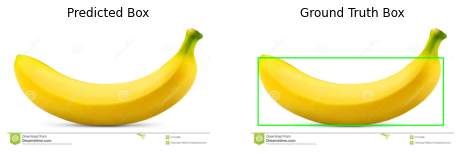

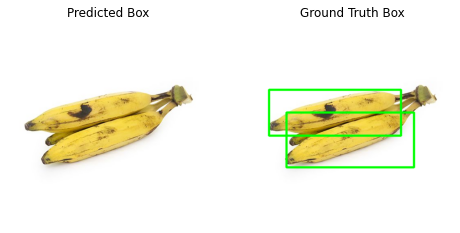

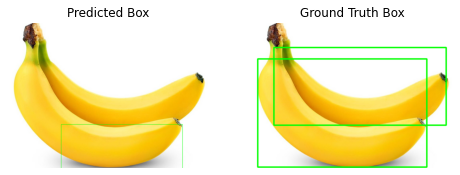

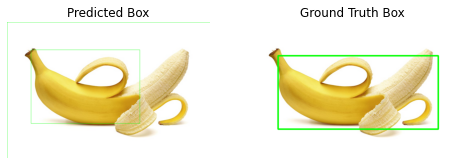

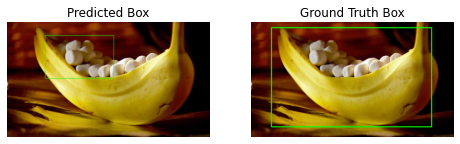

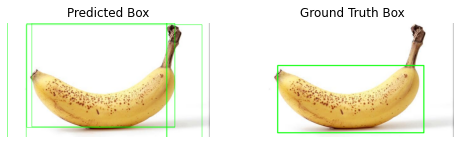

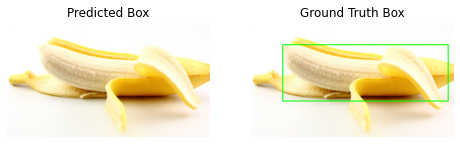

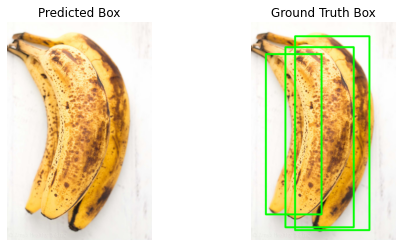

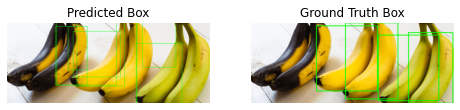

In [19]:
# test 결과 살펴보기            
compare_image(test_image, test_anno, test_predicted)